In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
import math
from joblib import Parallel, delayed
from torch.amp import autocast, GradScaler

In [2]:
def get_device():
    if torch.cuda.is_available():
        gpu_index = 0  # Always use GPU 0
        torch.cuda.set_device(gpu_index)  # Explicitly set the active GPU
        print(f"Using GPU {gpu_index}: {torch.cuda.get_device_name(gpu_index)}")
        return torch.device(f'cuda:{gpu_index}')
    
    print("No GPU available, using CPU")
    return torch.device('cpu')

In [3]:
class MultiStepRealEstateDataset(Dataset):
    def __init__(self, data, prediction_length=60):
        super().__init__()
        self.prediction_length = prediction_length
        
        # Convert all inputs to torch tensors with explicit float32 dtype
        self.basic_spatial = torch.FloatTensor(
            data[['latitude', 'longitude', 'neighbourhood_cleansed_encoded']].values
        ).float()
        
        self.enhanced_spatial = torch.FloatTensor(data[[
            'distance_to_center', 'north_south', 'knn_price_mean',
            'knn_price_std', 'price_diff_from_neighbors'
        ]].values).float()
        
        self.time_features = self._create_future_time_features(data)
        
        self.price_history = torch.FloatTensor(data[[
            'price_lag_90d', 'price_lag_120d', 
            'price_lag_150d', 'price_lag_180d'
        ]].values).float()
        
        self.rolling_features = torch.FloatTensor(data[[
            'rolling_mean_30d', 'rolling_std_30d', 'rolling_max_30d', 'rolling_min_30d',
            'rolling_mean_60d', 'rolling_std_60d', 'rolling_max_60d', 'rolling_min_60d',
            'rolling_mean_90d', 'rolling_std_90d', 'rolling_max_90d', 'rolling_min_90d'
        ]].values).float()
        
        self.future_prices = self._create_future_price_targets(data)

    def _create_future_time_features(self, data):
        base_dates = pd.to_datetime(data['date'])
        features = torch.FloatTensor(np.column_stack([
            base_dates.dt.dayofweek / 6.0,
            base_dates.dt.month / 12.0,
            base_dates.dt.dayofweek >= 5,
            np.sin(2 * np.pi * base_dates.dt.dayofyear / 365),
            np.cos(2 * np.pi * base_dates.dt.dayofyear / 365)
        ])).float()
        return features

    def _create_future_price_targets(self, data):
        if 'price' in data.columns:
            return torch.FloatTensor(data['price'].values).float()
        return torch.zeros(len(data)).float()
    
    def __len__(self):
        return len(self.future_prices)
    
    def __getitem__(self, idx):
        return {
            'basic_spatial': self.basic_spatial[idx],
            'enhanced_spatial': self.enhanced_spatial[idx],
            'time': self.time_features[idx],
            'price_history': self.price_history[idx],
            'rolling': self.rolling_features[idx],
            'future_prices': self.future_prices[idx]
        }

class MultiStepRealEstateNN(nn.Module):
    def __init__(self, feature_dims, prediction_length=60):
        super().__init__()
        
        # Spatial Encoder
        self.spatial_encoder = nn.Sequential(
            nn.Linear(feature_dims['basic_spatial'] + feature_dims['enhanced_spatial'], 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Time Encoder
        self.time_encoder = nn.Sequential(
            nn.Linear(feature_dims['time'], 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Price History Encoder
        self.price_history_gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.4
        )
        
        # Rolling Features Encoder
        self.rolling_encoder = nn.Sequential(
            nn.Linear(feature_dims['rolling'], 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Combined Features Processing
        combined_dim = 32 + 16 + 32 + 32  # spatial + time + price_history + rolling
        self.predictor = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single price prediction
        )
        
    def forward(self, basic_spatial, enhanced_spatial, time, price_history, rolling):
        # Process spatial features
        spatial_input = torch.cat([basic_spatial, enhanced_spatial], dim=1)
        spatial_encoding = self.spatial_encoder(spatial_input)
        
        # Process time features
        time_encoding = self.time_encoder(time)
        
        # Process price history
        price_history = price_history.unsqueeze(-1)  # Add feature dimension
        _, price_hidden = self.price_history_gru(price_history)
        price_encoding = price_hidden[-1]
        
        # Process rolling features
        rolling_encoding = self.rolling_encoder(rolling)
        
        # Combine all features
        combined = torch.cat([
            spatial_encoding,
            time_encoding,
            price_encoding,
            rolling_encoding
        ], dim=1)
        
        # Generate prediction
        output = self.predictor(combined)
        
        return output.squeeze(-1)

class MultiStepRealEstateTrainer:
    def __init__(self, feature_dims, prediction_length=60, device='cuda'):
        self.device = torch.device(device)
        self.prediction_length = prediction_length
        self.model = MultiStepRealEstateNN(feature_dims, prediction_length).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=0.01)
        self.scaler = GradScaler('cuda')  # Updated to new syntax
        
    def train_epoch(self, train_loader, epoch_num):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch_num}')
        
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to GPU
            batch = {k: v.to(self.device, non_blocking=True) for k, v in batch.items()}
            
            # Mixed precision training with updated syntax
            with autocast(device_type='cuda'):
                self.optimizer.zero_grad()
                predictions = self.model(
                    batch['basic_spatial'],
                    batch['enhanced_spatial'],
                    batch['time'],
                    batch['price_history'],
                    batch['rolling']
                )
                loss = self.criterion(predictions, batch['future_prices'])
            
            # Backward pass with gradient scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            # Update progress bar
            total_loss += loss.item()
            avg_loss = total_loss / (batch_idx + 1)
            progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
            
        return total_loss / len(train_loader)

    @torch.no_grad()
    def evaluate(self, val_loader):
        """
        Evaluate the model on the validation set
        """
        self.model.eval()
        total_loss = 0
        all_predictions = []
        
        for batch in tqdm(val_loader, desc='Evaluating'):
            # Move batch to GPU
            batch = {k: v.to(self.device, non_blocking=True) for k, v in batch.items()}
            
            # Forward pass with updated syntax
            with autocast(device_type='cuda'):
                predictions = self.model(
                    batch['basic_spatial'],
                    batch['enhanced_spatial'],
                    batch['time'],
                    batch['price_history'],
                    batch['rolling']
                )
                loss = self.criterion(predictions, batch['future_prices'])
            
            total_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())
            
        # Calculate average loss
        avg_loss = total_loss / len(val_loader)
        
        # Concatenate all predictions
        all_predictions = np.concatenate(all_predictions)
        
        return avg_loss, all_predictions

def train_model(trainer, train_loader, val_loader, num_epochs=50, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    best_predictions = None
    
    for epoch in range(num_epochs):
        # Train
        train_loss = trainer.train_epoch(train_loader, epoch)
        train_losses.append(train_loss)
        
        # Validate
        val_loss, predictions = trainer.evaluate(val_loader)
        val_losses.append(val_loss)
        
        # Print progress
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        
        # Save best model and predictions
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_predictions = predictions
            patience_counter = 0
            torch.save(trainer.model.state_dict(), 'best_model.pth')
            print('Saved new best model')
        else:
            patience_counter += 1
            
        # Early stopping check
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break
    
    return train_losses, val_losses, best_predictions

In [4]:
# Load preprocessed data
print("Loading preprocessed data...")
train_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\train_data_2024.csv')
test_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\test_data_2025.csv')
print("Data loaded successfully.")

# Reduce the number of unique listings for testing and development
n_train_listings = 500 
n_test_listings = 500

# Get random sample of unique listing IDs
train_listings = train_data['listing_id'].unique()
np.random.seed(42)
selected_train_listings = np.random.choice(train_listings, n_train_listings, replace=False)

# Filter train data to keep all rows for selected listings
train_data = train_data[train_data['listing_id'].isin(selected_train_listings)]

# Do the same for test data
test_listings = test_data['listing_id'].unique()
selected_test_listings = np.random.choice(test_listings, n_test_listings, replace=False)
test_data = test_data[test_data['listing_id'].isin(selected_test_listings)]

print(f"Reduced to {n_train_listings} training listings and {n_test_listings} test listings")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Loading preprocessed data...
Data loaded successfully.
Reduced to 500 training listings and 500 test listings
Training data shape: (172430, 27)
Test data shape: (30500, 27)


In [13]:
import pandas as pd

# Load both datasets
encoded_df = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\train_data_2024.csv')
original_df = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\listings.csv')

# Get unique listing_ids and their encoded neighborhoods from the encoded dataset
encoded_neighborhoods = encoded_df[['listing_id', 'neighbourhood_cleansed_encoded']].drop_duplicates()

# Get unique listing_ids and their original neighborhoods from the original dataset
original_neighborhoods = original_df[['id', 'neighbourhood_cleansed']].drop_duplicates()
# Ensure id is treated as listing_id
original_neighborhoods = original_neighborhoods.rename(columns={'id': 'listing_id'})

# Merge the two dataframes on listing_id
neighborhood_mapping = pd.merge(
    encoded_neighborhoods, 
    original_neighborhoods, 
    on='listing_id',
    how='inner'
)

# Create a mapping dictionary of encoded values to original names
mapping_dict = neighborhood_mapping.groupby('neighbourhood_cleansed_encoded')['neighbourhood_cleansed'].first()

# Convert to a more readable DataFrame
mapping_df = mapping_dict.reset_index()
mapping_df.columns = ['Encoded_Value', 'Neighborhood']
mapping_df = mapping_df.sort_values('Encoded_Value')

print("\nNeighborhood Mapping:")
print(mapping_df.to_string(index=False))

# Optional: Save mapping to CSV
# mapping_df.to_csv('neighborhood_mapping.csv', index=False)


Neighborhood Mapping:
 Encoded_Value        Neighborhood
             0 Batignolles-Monceau
             1              Bourse
             2     Buttes-Chaumont
             3   Buttes-Montmartre
             4            Entrepôt
             5            Gobelins
             6      Hôtel-de-Ville
             7              Louvre
             8          Luxembourg
             9        Ménilmontant
            10        Observatoire
            11               Opéra
            12      Palais-Bourbon
            13            Panthéon
            14               Passy
            15          Popincourt
            16             Reuilly
            17              Temple
            18           Vaugirard
            19              Élysée


In [5]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        distances, indices = tree.query(coords, k=k_neighbors + 1)
        
        # Convert distances to weights (inverse distance weighting)
        weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        return {
            'knn_price_mean': np.nanmean(neighbor_prices, axis=1),
            'knn_price_std': np.nanstd(neighbor_prices, axis=1),
            'knn_price_median': np.nanmedian(neighbor_prices, axis=1),
            'knn_price_range': np.ptp(neighbor_prices, axis=1),
            'price_diff_from_neighbors': chunk_data['price'].values - np.nanmean(neighbor_prices, axis=1),
            'distance_weighted_price': np.sum(weights * neighbor_prices, axis=1)
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            k_neighbors,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        spatial_features[col] = (spatial_features[col] - spatial_features[col].mean()) / spatial_features[col].std()
    
    return spatial_features

In [6]:
# Add spatial features
print("Creating spatial features for training data...")
train_spatial = create_spatial_features(train_data)
print("Spatial features for training data created.")

print("Creating spatial features for test data...")
test_spatial = create_spatial_features(test_data)
print("Spatial features for test data created.")

# Combine with existing features
print("Combining spatial features with existing features...")
X_train = pd.concat([train_data, train_spatial], axis=1)  # Keep all columns including price
X_test = pd.concat([test_data, test_spatial], axis=1)  # Keep all columns including price
print("Features combined.")

test_dates = pd.to_datetime(test_data['date'])

Creating spatial features for training data...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Spatial features for training data created.
Creating spatial features for test data...
Spatial features for test data created.
Combining spatial features with existing features...
Features combined.


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
# Get device
device = get_device()  # This uses your existing get_device() function

# Initialize feature dimensions
feature_dims = {
    'basic_spatial': 3,  # latitude, longitude, neighbourhood
    'enhanced_spatial': 5,  # distance_to_center, north_south, etc.
    'time': 5,  # day of week, month, is_weekend, season sine/cosine
    'price_history': 4,  # 90d, 120d, 150d, 180d lags
    'rolling': 12  # rolling means, stds, max, mins
}

# Create the datasets - using your existing temporal split
train_dataset = MultiStepRealEstateDataset(X_train, prediction_length=60)
test_dataset = MultiStepRealEstateDataset(X_test, prediction_length=60)

# Setup data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    pin_memory=True,
    num_workers=0
)

# Initialize trainer
trainer = MultiStepRealEstateTrainer(
    feature_dims=feature_dims,
    prediction_length=60,
    device=device
)

# Train model using test set for validation
train_losses, val_losses, predictions = train_model(trainer, train_loader, test_loader)

# Get final predictions on test set
test_loss, test_predictions = trainer.evaluate(test_loader)
print(f'\nTest Loss: {test_loss:.4f}')

Using GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 426.51it/s]



Epoch 1/50:
Train Loss: 0.0833
Val Loss: 0.0224
Saved new best model


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 454.76it/s]



Epoch 2/50:
Train Loss: 0.0699
Val Loss: 0.0106
Saved new best model


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 422.17it/s]



Epoch 3/50:
Train Loss: 0.0698
Val Loss: 0.0034
Saved new best model


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 447.94it/s]



Epoch 4/50:
Train Loss: 0.0679
Val Loss: 0.0090


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 437.54it/s]



Epoch 5/50:
Train Loss: 0.0655
Val Loss: 0.0115


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 451.89it/s]



Epoch 6/50:
Train Loss: 0.0669
Val Loss: 0.0042


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 421.63it/s]



Epoch 7/50:
Train Loss: 0.0638
Val Loss: 0.0109


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 455.52it/s]



Epoch 8/50:
Train Loss: 0.0630
Val Loss: 0.0032
Saved new best model


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 476.42it/s]



Epoch 9/50:
Train Loss: 0.0608
Val Loss: 0.0084


Evaluating: 100%|██████████| 954/954 [00:01<00:00, 477.14it/s]



Epoch 10/50:
Train Loss: 0.0645
Val Loss: 0.0169


Evaluating: 100%|██████████| 954/954 [00:01<00:00, 490.15it/s]



Epoch 11/50:
Train Loss: 0.0648
Val Loss: 0.0034


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 465.82it/s]



Epoch 12/50:
Train Loss: 0.0643
Val Loss: 0.0079


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 453.33it/s]



Epoch 13/50:
Train Loss: 0.0639
Val Loss: 0.0072
Early stopping triggered after 13 epochs


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 476.84it/s]


Test Loss: 0.0072


Evaluating: 100%|██████████| 954/954 [00:02<00:00, 464.44it/s]



Final Test Loss: 0.0072

=== Final Enhanced Model Performance ===
RMSE: 0.0848
MAE: 0.0388
R2: 0.9937
MAPE: 12.0670

=== Spatiotemporal Analysis ===

Monthly Error Analysis:
         AbsError          
             mean       std
Date                       
2025-04  0.038803  0.075455
2025-05  0.038803  0.075455

Neighborhood Error Analysis:
                     AbsError                
                         mean       std count
Neighborhood                                 
Batignolles-Monceau  0.052164  0.104988  2318
Bourse               0.020997  0.014497   732
Buttes-Chaumont      0.023168  0.025595  1525
Buttes-Montmartre    0.038904  0.045939  3843
Entrepôt             0.034106  0.037800  2135
Gobelins             0.050488  0.054565   793
Hôtel-de-Ville       0.025433  0.022006   976
Louvre               0.044124  0.034535   732
Luxembourg           0.023047  0.027570   671
Ménilmontant         0.045539  0.053652  2013
Observatoire         0.071438  0.120155  1159
Opéra      

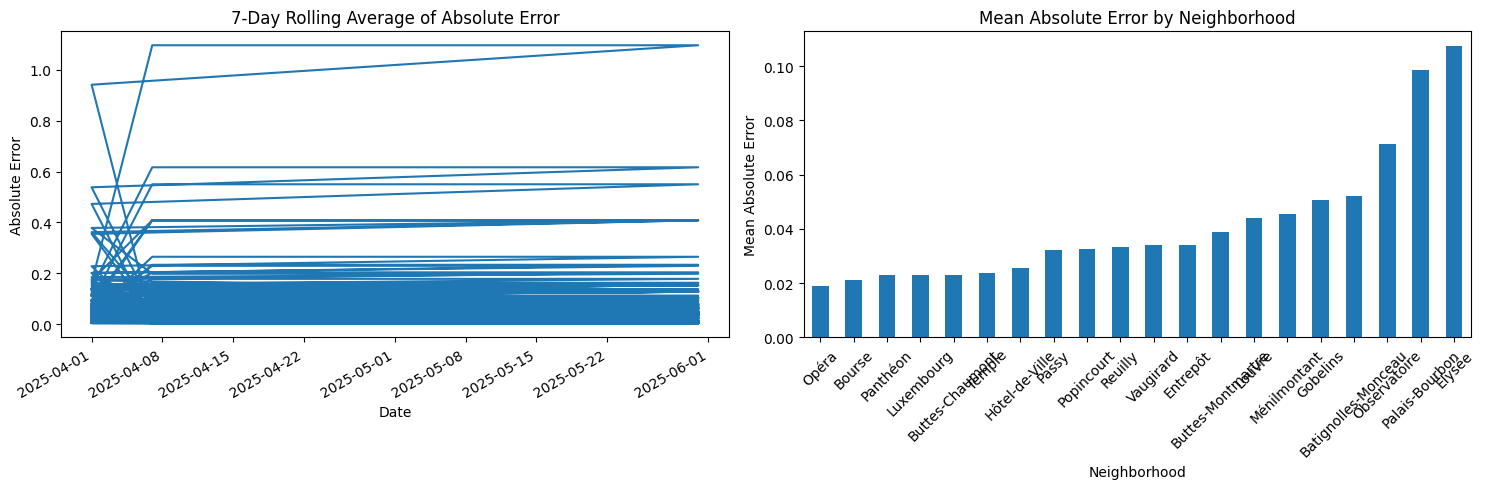


Saving model and predictions...

Evaluation complete!


In [ ]:
# First get predictions on the test set using the best model
test_loss, test_predictions = trainer.evaluate(test_loader)
print(f'\nFinal Test Loss: {test_loss:.4f}')

# Calculate metrics
true_prices = X_test['price'].values  # Changed from y_test to X_test['price']
metrics = {
    'rmse': np.sqrt(mean_squared_error(true_prices, test_predictions)),
    'mae': mean_absolute_error(true_prices, test_predictions),
    'r2': r2_score(true_prices, test_predictions),
    'mape': np.mean(np.abs((true_prices - test_predictions) / true_prices)) * 100
}

# Print traditional metrics
print("\n=== Final Enhanced Model Performance ===")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

# Additional spatiotemporal analysis
print("\n=== Spatiotemporal Analysis ===")

# Analyze temporal performance
monthly_performance = pd.DataFrame({
    'Date': pd.to_datetime(test_data['date']),
    'True': true_prices,
    'Predicted': test_predictions,
    'AbsError': np.abs(true_prices - test_predictions)
})
monthly_errors = monthly_performance.groupby(monthly_performance['Date'].dt.strftime('%Y-%m'))[['AbsError']].agg(['mean', 'std'])
print("\nMonthly Error Analysis:")
print(monthly_errors)

# Analyze temporal performance
monthly_performance = pd.DataFrame({
    'Date': pd.to_datetime(test_data['date']),
    'True': true_prices,
    'Predicted': test_predictions,
    'AbsError': np.abs(true_prices - test_predictions)
})
monthly_errors = monthly_performance.groupby(monthly_performance['Date'].dt.strftime('%Y-%m'))[['AbsError']].agg(['mean', 'std'])
print("\nMonthly Error Analysis:")
print(monthly_errors)

# Analyze spatial performance with neighborhood names
neighborhood_mapping = {
    0: 'Batignolles-Monceau',
    1: 'Bourse',
    2: 'Buttes-Chaumont',
    3: 'Buttes-Montmartre',
    4: 'Entrepôt',
    5: 'Gobelins',
    6: 'Hôtel-de-Ville',
    7: 'Louvre',
    8: 'Luxembourg',
    9: 'Ménilmontant',
    10: 'Observatoire',
    11: 'Opéra',
    12: 'Palais-Bourbon',
    13: 'Panthéon',
    14: 'Passy',
    15: 'Popincourt',
    16: 'Reuilly',
    17: 'Temple',
    18: 'Vaugirard',
    19: 'Élysée'
}

spatial_performance['Neighborhood'] = spatial_performance['Neighborhood'].map(neighborhood_mapping)
neighborhood_errors = spatial_performance.groupby('Neighborhood')[['AbsError']].agg(['mean', 'std', 'count'])
print("\nNeighborhood Error Analysis:")
print(neighborhood_errors)

# Create visualization of errors over time and space
plt.figure(figsize=(15, 5))

# Temporal error plot
plt.subplot(1, 2, 1)
monthly_performance.set_index('Date')['AbsError'].rolling(window=7).mean().plot()
plt.title('7-Day Rolling Average of Absolute Error')
plt.xlabel('Date')
plt.ylabel('Absolute Error')

# Spatial error plot
plt.subplot(1, 2, 2)
neighborhood_errors['AbsError']['mean'].sort_values().plot(kind='bar')
plt.title('Mean Absolute Error by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save model and predictions
print("\nSaving model and predictions...")
torch.save(trainer.model.state_dict(), 'enhanced_model_final.pth')
np.save('enhanced_predictions.npy', test_predictions)

print("\nEvaluation complete!")

spatial_performance['Neighborhood'] = spatial_performance['Neighborhood'].map(neighborhood_mapping)
neighborhood_errors = spatial_performance.groupby('Neighborhood')[['AbsError']].agg(['mean', 'std', 'count'])
print("\nNeighborhood Error Analysis:")
print(neighborhood_errors)

# Create visualization of errors over time and space
plt.figure(figsize=(15, 5))

# Temporal error plot
plt.subplot(1, 2, 1)
monthly_performance.set_index('Date')['AbsError'].rolling(window=7).mean().plot()
plt.title('7-Day Rolling Average of Absolute Error')
plt.xlabel('Date')
plt.ylabel('Absolute Error')

# Spatial error plot
plt.subplot(1, 2, 2)
neighborhood_errors['AbsError']['mean'].sort_values().plot(kind='bar')
plt.title('Mean Absolute Error by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save model and predictions
print("\nSaving model and predictions...")
torch.save(trainer.model.state_dict(), 'enhanced_model_final.pth')
np.save('enhanced_predictions.npy', test_predictions)

print("\nEvaluation complete!")


=== Error Autocorrelation Analysis ===

Error Autocorrelations:
Lag 1 day(s): 0.9829
Lag 2 day(s): 0.9658
Lag 3 day(s): 0.9487
Lag 4 day(s): 0.9316
Lag 5 day(s): 0.9145
Lag 6 day(s): 0.8974
Lag 7 day(s): 0.8803


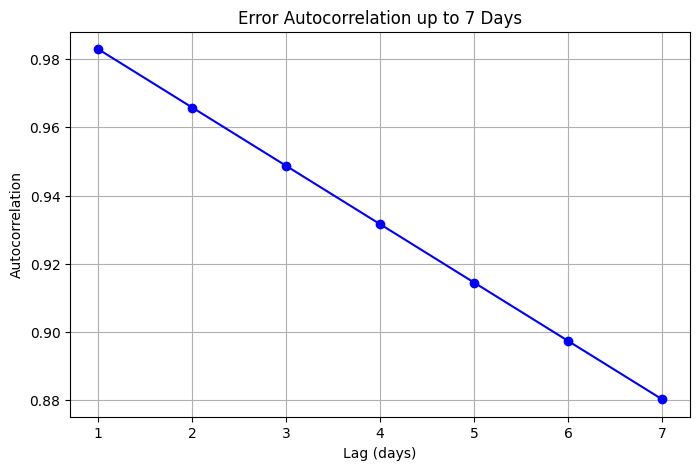

In [12]:
# After calculating basic metrics
print("\n=== Error Autocorrelation Analysis ===")

# Calculate error series
errors = true_prices - predictions
error_series = pd.Series(errors, index=pd.to_datetime(test_data['date']))

# Calculate autocorrelations for lags 1-7
lags = range(1, 8)  # 1 to 7 days
autocorrs = []

for lag in lags:
    autocorr = error_series.autocorr(lag=lag)
    autocorrs.append({
        'lag': lag,
        'autocorrelation': autocorr
    })

# Display results
print("\nError Autocorrelations:")
for result in autocorrs:
    print(f"Lag {result['lag']} day(s): {result['autocorrelation']:.4f}")

# Simple plot of autocorrelations
plt.figure(figsize=(8, 5))
plt.plot([r['lag'] for r in autocorrs], [r['autocorrelation'] for r in autocorrs], 'bo-')
plt.title('Error Autocorrelation up to 7 Days')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()